<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Yalda Shabanzadeh - Yasaman Zolfi Moselo 
### Student Number : 98101822 - 98105795
___

# Introduction

In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.

# Data Documentation

For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data. 
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "_mut" at the end of the names of the columns) 
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

# Import Libreries

In [ ]:
!pip install umap-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Data Preparation (15 Points)

In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)

## Data Loading & Splitting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/ML_project
# cd /content/drive/MyDrive/Colab_Notebooks/ML_project

/content/drive/.shortcut-targets-by-id/1IbtxjLs90XjvuJ9gG0RlhmdiaRf-fAJI/ML_project


In [ ]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv', low_memory=False)
df.head(5)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(1904, 693)

In [ ]:
clinical_df = df.iloc[:, :31]

In [ ]:
gene_exp_df = df.iloc[:, 31:520]

In [ ]:
gene_mutation_df = df.iloc[:, 520:]

In [ ]:
print(
    f'shape of clinical dataset is {clinical_df.shape}',
    f'shape of gene expressions dataset is {gene_exp_df.shape}',
    f'shape of gene mutation dataset is {gene_mutation_df.shape}',
    sep='\n'
)

shape of clinical dataset is (1904, 31)
shape of gene expressions dataset is (1904, 489)
shape of gene mutation dataset is (1904, 173)


## EDA

For each dataset, you must perform a sufficient EDA.

In [ ]:
# general methods

def analyze_null(df):
    null_df = pd.merge(df.isna().sum().to_frame("null_count"), df.count().to_frame("not_null_count"), left_index=True, right_index=True)
    null_df["null_percent"] = null_df["null_count"] / (null_df["null_count"] + null_df["not_null_count"])
    null_df[null_df["null_count"] > 0]
    return null_df


def encode(df, encoder, cols):
    for col in cols:
        encoded = encoder.fit_transform(df[col])
        df.drop(col, axis=1, inplace=True)
        df[col] = encoded


def fill_null(df, categorical_cols, numerical_cols):
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())


def filter_df(df, filtered_list):
    return df[pd.Series(df.index).apply(lambda x: x in filtered_list)]

### Clinical Dataset

In [ ]:
clinical_df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [ ]:
clinical_df.columns

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

In [ ]:
clinical_df.describe()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
count,1904.000000,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,1904.000000,1904.000000,1884.000000,1403.000000
mean,3921.982143,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,0.420693,0.597164,26.238726,1.750535
std,2358.478332,12.978711,0.405971,1.228615,0.650612,0.486343,4.079993,4.058778,1.144492,76.334148,0.493800,0.490597,15.160976,0.628999
min,0.000000,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,896.500000,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,0.000000,0.000000,17.000000,1.000000
50%,4730.500000,61.770000,0.000000,3.000000,3.000000,1.000000,0.000000,5.000000,4.042000,115.616667,0.000000,1.000000,23.000000,2.000000
75%,5536.250000,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,1.000000,1.000000,30.000000,2.000000
max,7299.000000,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,1.000000,182.000000,4.000000


In [ ]:
clinical_df.duplicated().sum()

0

In [ ]:
analyze_null(clinical_df)

,null_count,not_null_count,null_percent
patient_id,0,1904,0.000000
age_at_diagnosis,0,1904,0.000000
type_of_breast_surgery,22,1882,0.011555
cancer_type,0,1904,0.000000
cancer_type_detailed,15,1889,0.007878
cellularity,54,1850,0.028361
chemotherapy,0,1904,0.000000
pam50_+_claudin-low_subtype,0,1904,0.000000
cohort,0,1904,0.000000
er_status_measured_by_ihc,30,1874,0.015756


In [ ]:
clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

In [ ]:
clinical_df.isnull().sum()

patient_id                          0
age_at_diagnosis                    0
type_of_breast_surgery             22
cancer_type                         0
cancer_type_detailed               15
cellularity                        54
chemotherapy                        0
pam50_+_claudin-low_subtype         0
cohort                              0
er_status_measured_by_ihc          30
er_status                           0
neoplasm_histologic_grade          72
her2_status_measured_by_snp6        0
her2_status                         0
tumor_other_histologic_subtype     15
hormone_therapy                     0
inferred_menopausal_state           0
integrative_cluster                 0
primary_tumor_laterality          106
lymph_nodes_examined_positive       0
mutation_count                     45
nottingham_prognostic_index         0
oncotree_code                      15
overall_survival_months             0
overall_survival                    0
pr_status                           0
radio_therap

In [ ]:
# find columns with null values

null_df = clinical_df.isnull().sum()
null_columns = list(null_df[null_df > 0].index)
null_columns

['type_of_breast_surgery',
 'cancer_type_detailed',
 'cellularity',
 'er_status_measured_by_ihc',
 'neoplasm_histologic_grade',
 'tumor_other_histologic_subtype',
 'primary_tumor_laterality',
 'mutation_count',
 'oncotree_code',
 '3-gene_classifier_subtype',
 'tumor_size',
 'tumor_stage',
 'death_from_cancer']

In [ ]:
str_columns = list(clinical_df.dtypes.index[clinical_df.dtypes != 'float64'])[1:]
str_columns.extend(['cohort', 'neoplasm_histologic_grade', 'tumor_stage'])
str_columns

['type_of_breast_surgery',
 'cancer_type',
 'cancer_type_detailed',
 'cellularity',
 'chemotherapy',
 'pam50_+_claudin-low_subtype',
 'er_status_measured_by_ihc',
 'er_status',
 'her2_status_measured_by_snp6',
 'her2_status',
 'tumor_other_histologic_subtype',
 'hormone_therapy',
 'inferred_menopausal_state',
 'integrative_cluster',
 'primary_tumor_laterality',
 'oncotree_code',
 'overall_survival',
 'pr_status',
 'radio_therapy',
 '3-gene_classifier_subtype',
 'death_from_cancer',
 'cohort',
 'neoplasm_histologic_grade',
 'tumor_stage']

In [ ]:
len(str_columns)

24

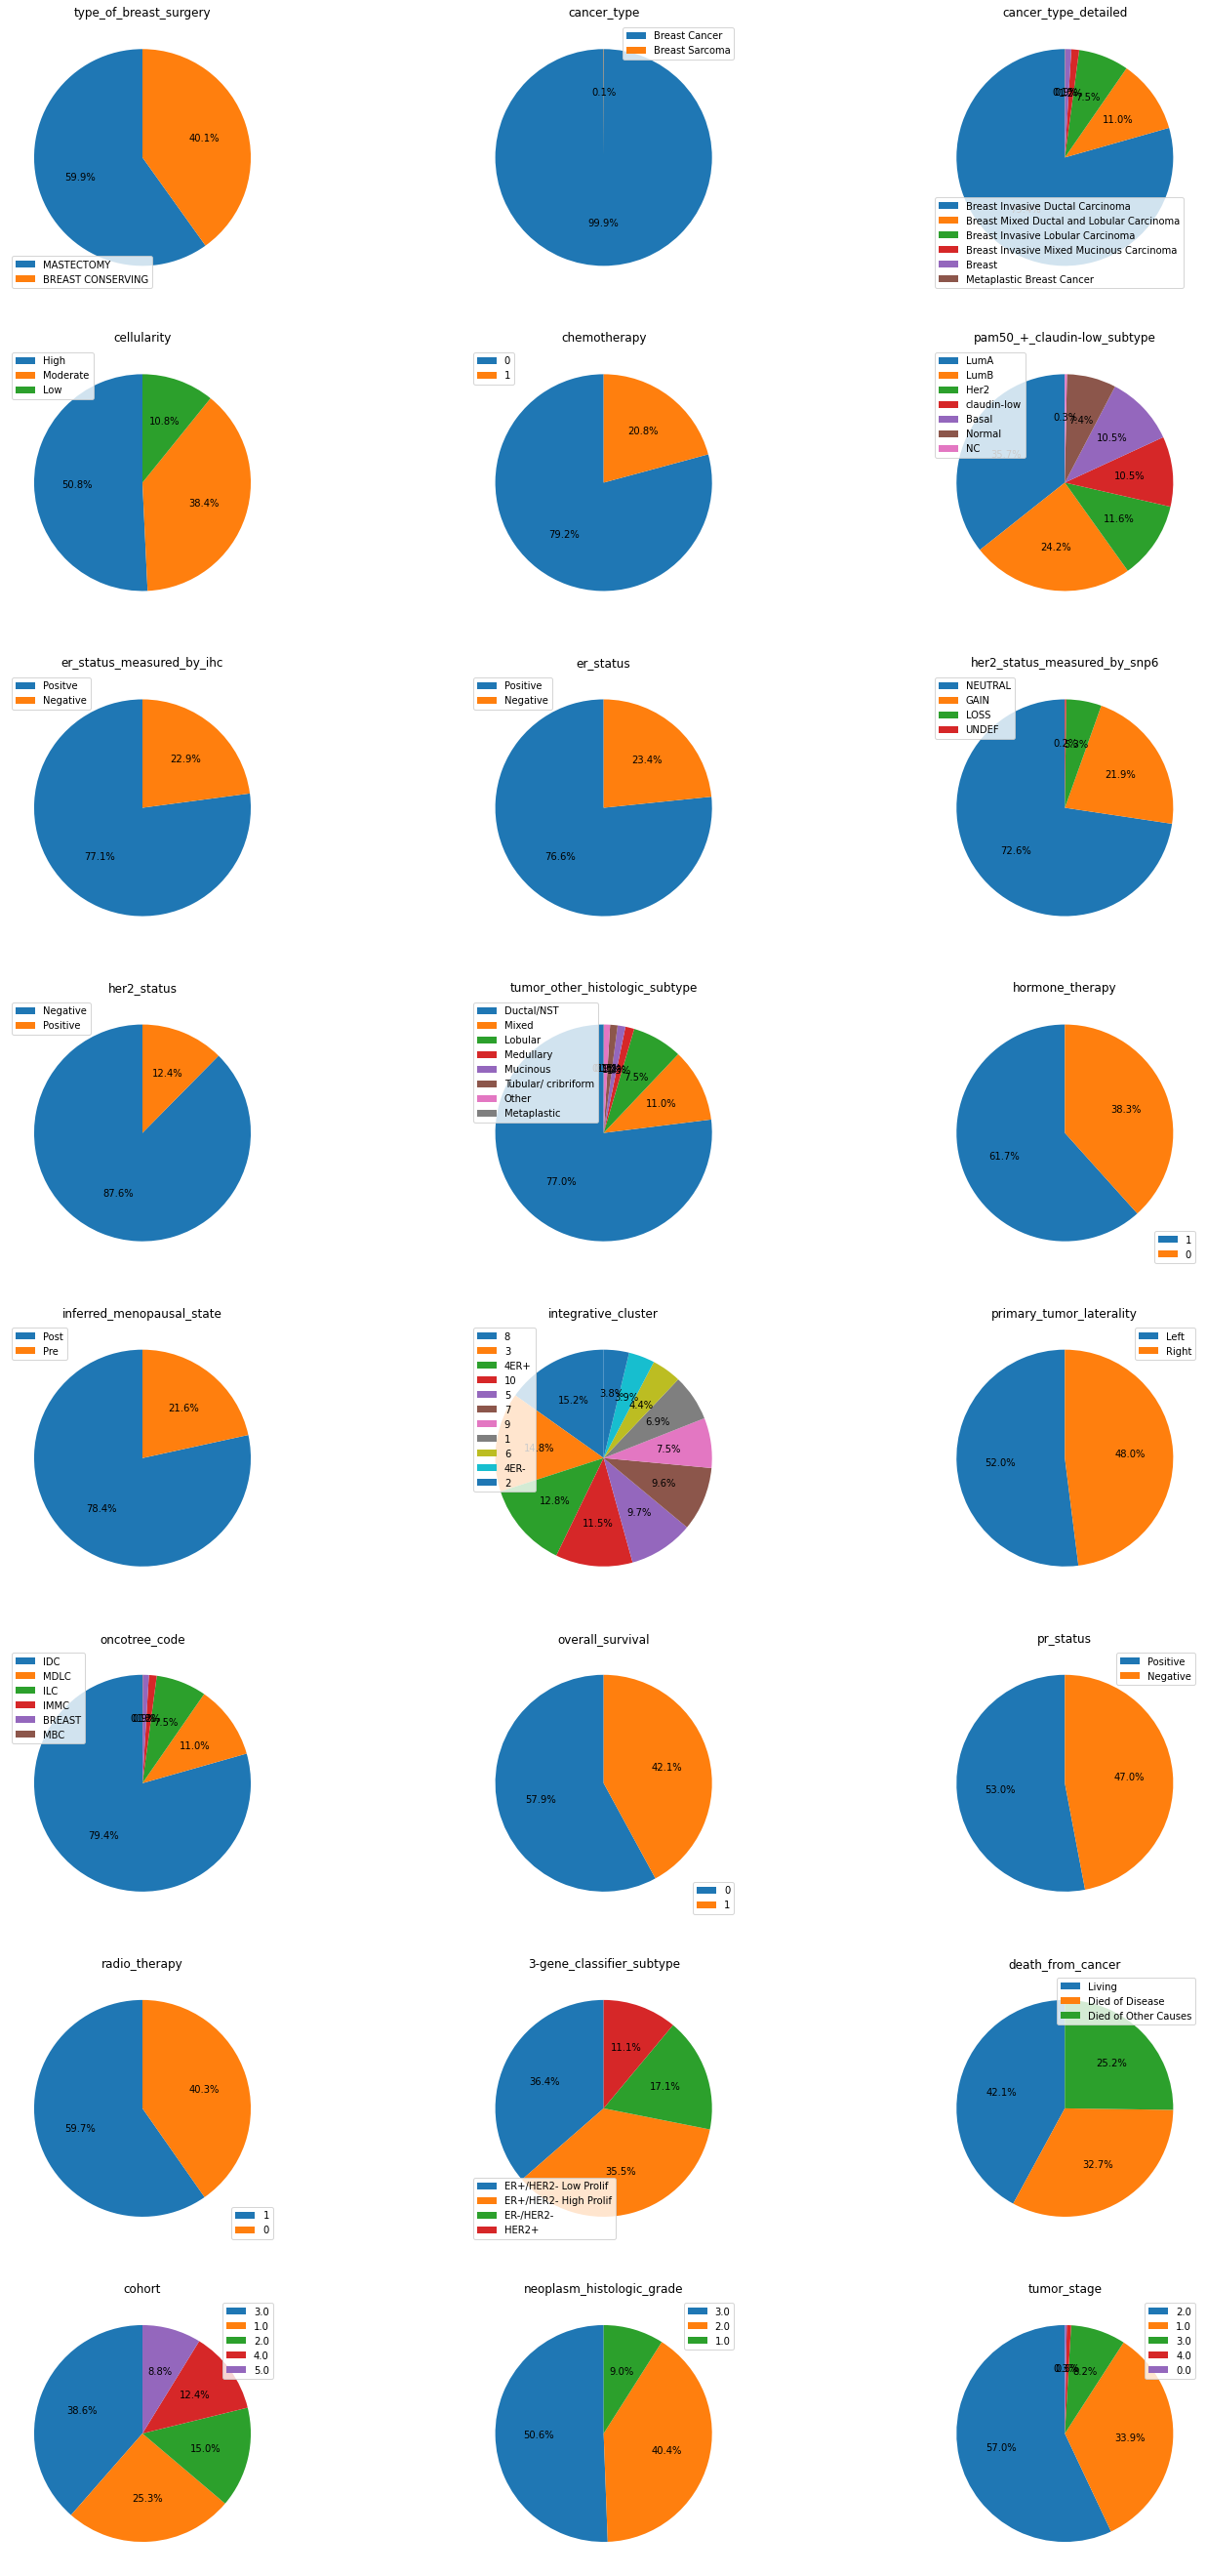

In [ ]:
# plot pie plots for categorical labels

figure = plt.figure(figsize=(24, 48))
i = 0
for col in str_columns:
    figure.add_subplot(8, 3, i+1)
    i += 1
    plt.pie(clinical_df[col].value_counts().values, autopct='%1.1f%%', startangle=90)
    plt.legend(labels=clinical_df[col].value_counts().index, loc="best")
    plt.title(col)
plt.show()

In [ ]:
# non-categorical describe of clinical dataset

clinical_df.describe()[clinical_df.dtypes.index[clinical_df.dtypes == 'float64']]

,age_at_diagnosis,cohort,neoplasm_histologic_grade,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,tumor_stage
count,1904.000000,1904.000000,1832.000000,1904.000000,1859.000000,1904.000000,1904.000000,1884.000000,1403.000000
mean,61.087054,2.643908,2.415939,2.002101,5.697687,4.033019,125.121324,26.238726,1.750535
std,12.978711,1.228615,0.650612,4.079993,4.058778,1.144492,76.334148,15.160976,0.628999
min,21.930000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,51.375000,1.000000,2.000000,0.000000,3.000000,3.046000,60.825000,17.000000,1.000000
50%,61.770000,3.000000,3.000000,0.000000,5.000000,4.042000,115.616667,23.000000,2.000000
75%,70.592500,3.000000,3.000000,2.000000,7.000000,5.040250,184.716667,30.000000,2.000000
max,96.290000,5.000000,3.000000,45.000000,80.000000,6.360000,355.200000,182.000000,4.000000


In [ ]:
set(null_columns).difference(set(str_columns))

{'mutation_count', 'tumor_size'}

> It shows that two non-categorical columns also have null values.

In [ ]:
categorical_cols = set(null_columns).intersection(set(str_columns))
numerical_cols = set(null_columns).difference(set(str_columns))

print(
    f'categorical columns are:\n{categorical_cols}',
    f'numerical columns are:\n{numerical_cols}',
    sep='\n'
)

categorical columns are:
{'oncotree_code', 'tumor_other_histologic_subtype', '3-gene_classifier_subtype', 'primary_tumor_laterality', 'cellularity', 'death_from_cancer', 'neoplasm_histologic_grade', 'cancer_type_detailed', 'tumor_stage', 'type_of_breast_surgery', 'er_status_measured_by_ihc'}
numerical columns are:
{'mutation_count', 'tumor_size'}


> To handle null values in dataset, we:
- fill categorical with mode of the data
- fill numerical with mean of the data

In [ ]:
fill_null(clinical_df, categorical_cols, numerical_cols)

In [ ]:
clinical_df.isnull().sum()

patient_id                        0
age_at_diagnosis                  0
type_of_breast_surgery            0
cancer_type                       0
cancer_type_detailed              0
cellularity                       0
chemotherapy                      0
pam50_+_claudin-low_subtype       0
cohort                            0
er_status_measured_by_ihc         0
er_status                         0
neoplasm_histologic_grade         0
her2_status_measured_by_snp6      0
her2_status                       0
tumor_other_histologic_subtype    0
hormone_therapy                   0
inferred_menopausal_state         0
integrative_cluster               0
primary_tumor_laterality          0
lymph_nodes_examined_positive     0
mutation_count                    0
nottingham_prognostic_index       0
oncotree_code                     0
overall_survival_months           0
overall_survival                  0
pr_status                         0
radio_therapy                     0
3-gene_classifier_subtype   

> It shows that we fixed null values. Now we have to encode categorical values (with `LabelEncoder`)

In [ ]:
# use label encoding for all str cols

le = LabelEncoder()
le_clinical_df = clinical_df.copy()
encode(le_clinical_df, le, str_columns)
le_clinical_df.head()

,patient_id,age_at_diagnosis,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,tumor_size,type_of_breast_surgery,cancer_type,cancer_type_detailed,...,primary_tumor_laterality,oncotree_code,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,death_from_cancer,cohort,neoplasm_histologic_grade,tumor_stage
0,0,75.65,10.0,5.0,6.044,140.500000,22.0,1,0,1,...,1,1,1,0,1,2,2,0,2,2
1,2,43.19,0.0,2.0,4.020,84.633333,10.0,0,0,1,...,1,1,1,1,1,0,2,0,2,1
2,5,48.87,1.0,2.0,4.030,163.700000,15.0,1,0,1,...,1,1,0,1,0,1,0,0,1,2
3,6,47.68,3.0,1.0,4.050,164.933333,25.0,1,0,4,...,1,5,1,1,1,1,2,0,1,2
4,8,76.97,8.0,2.0,6.080,41.366667,40.0,1,0,4,...,1,5,0,1,1,0,0,0,2,2


In [ ]:
# - nulls (https://pythonsansar.com/how-to-handle-null-values-in-pandas/)
# - encode categorical format (https://pbpython.com/categorical-encoding.html)

### Gene Expressions Dataset

In [ ]:
gene_exp_df.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


In [ ]:
gene_exp_df.columns

Index(['brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2',
       'nbn', 'nf1',
       ...
       'srd5a1', 'srd5a2', 'srd5a3', 'st7', 'star', 'tnk2', 'tulp4', 'ugt2b15',
       'ugt2b17', 'ugt2b7'],
      dtype='object', length=489)

In [ ]:
gene_exp_df.describe()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,...,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03
mean,-6.302521e-07,-4.201681e-07,3.676471e-07,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,7.463684e-18,-3.676471e-07,-0.000001,...,4.726891e-07,-3.676471e-07,-9.453782e-07,-1.050420e-07,-0.000002,3.676471e-07,4.726891e-07,7.878151e-07,0.000000,3.731842e-18
std,1.000262e+00,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,...,1.000263e+00,1.000262e+00,1.000262e+00,1.000263e+00,1.000262,1.000264e+00,1.000262e+00,1.000263e+00,1.000262,1.000262e+00
min,-2.444400e+00,-2.783500e+00,-4.384600e+00,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,...,-2.120800e+00,-3.364800e+00,-2.719400e+00,-4.982700e+00,-2.981700,-3.833300e+00,-3.609300e+00,-1.166900e+00,-2.112600,-1.051600e+00
25%,-7.198500e-01,-6.994750e-01,-6.798250e-01,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,...,-6.188500e-01,-6.104750e-01,-6.741750e-01,-6.136750e-01,-0.632900,-6.664750e-01,-7.102000e-01,-5.058250e-01,-0.476200,-7.260000e-01
50%,-1.244500e-01,-5.820000e-02,-2.210000e-02,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,...,-2.456500e-01,-4.690000e-02,-1.422500e-01,-5.175000e-02,-0.026650,7.000000e-04,-2.980000e-02,-2.885500e-01,-0.133400,-4.248000e-01
75%,5.532250e-01,6.290000e-01,6.400000e-01,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,...,3.306000e-01,5.144500e-01,5.146000e-01,5.787750e-01,0.590350,6.429000e-01,5.957250e-01,6.022500e-02,0.270375,4.284000e-01
max,4.554200e+00,3.737900e+00,4.615000e+00,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,...,6.534900e+00,1.027030e+01,6.329000e+00,4.571300e+00,12.742300,3.938800e+00,3.833400e+00,1.088490e+01,12.643900,3.284400e+00


In [ ]:
gene_exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 489 entries, brca1 to ugt2b7
dtypes: float64(489)
memory usage: 7.1 MB


In [ ]:
gene_exp_df.duplicated().sum()

0

In [ ]:
# find columns with null values

null_df = clinical_df.isnull().sum()
null_columns = list(null_df[null_df > 0].index)
null_columns

[]

In [ ]:
analyze_null(gene_exp_df)

,null_count,not_null_count,null_percent
brca1,0,1904,0.0
brca2,0,1904,0.0
palb2,0,1904,0.0
pten,0,1904,0.0
tp53,0,1904,0.0
...,...,...,...
tnk2,0,1904,0.0
tulp4,0,1904,0.0
ugt2b15,0,1904,0.0
ugt2b17,0,1904,0.0


> There is no null values in gene expressions dataset.

## Train-Test Split


In [ ]:
train_patients, test_patients = train_test_split(
    list(gene_exp_df.index), test_size=0.3, random_state=42
)

In [ ]:
gene_exp_df_train = filter_df(gene_exp_df, train_patients)
gene_exp_df_test = filter_df(gene_exp_df, test_patients)
clinical_df_train = filter_df(le_clinical_df, train_patients)
clinical_df_test = filter_df(le_clinical_df, test_patients)

In [ ]:
print(f"length of train set: {len(train_patients)}")
print(f"length of test set: {len(test_patients)}")

length of train set: 1332
length of test set: 572


In [ ]:
print('shapes are:', 
      f'\tgene exp train: {gene_exp_df_train.shape}',
      f'\tgene exp test: {gene_exp_df_test.shape}',
      f'\tclinical train: {clinical_df_train.shape}',
      f'\tclinical test: {clinical_df_test.shape}',
      sep='\n')

shapes are:
	gene exp train: (1332, 489)
	gene exp test: (572, 489)
	clinical train: (1332, 31)
	clinical test: (572, 31)


## Dimension Reduction (20 + Up to 10 Points Optional)

For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.

Gene expressions dataset needs dimension reduction.

### Feature Importance

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 20 features for the dataset.

In [ ]:
target_column = 'overall_survival'
X = filter_df(gene_exp_df, train_patients)
y = filter_df(le_clinical_df, train_patients)[target_column]
data = X.join(y)

data

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,overall_survival
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354,1
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920,1
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655,0
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828,1
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,0.9244,-0.8580,-0.6622,1.4311,-1.3367,-0.0613,0.3168,0.9005,-1.5454,0.2894,...,0.8212,0.2662,2.8345,-0.4319,-1.4772,-1.4477,-0.1200,-0.6573,-0.5130,0
1899,0.1563,0.5543,-0.6149,0.4572,1.3822,-0.0537,-0.1323,0.2837,-0.0726,-0.5500,...,1.5304,1.1196,0.8116,0.0958,-1.2644,-0.3566,-0.2615,-0.6371,-0.5540,1
1900,0.1343,0.9128,1.3017,0.7383,0.1841,0.0028,0.1243,2.2040,-0.6190,-0.8681,...,-0.6610,-0.1610,0.2251,0.5127,-0.3412,-1.0703,-0.6950,0.0641,-0.8863,0
1901,1.8107,-0.2608,0.4006,-0.2985,0.0356,-0.1620,1.5486,1.5309,-1.3653,-0.2529,...,-0.5194,2.3968,0.5917,-0.8643,-1.3541,-1.8076,-0.1840,0.0967,-0.6264,0


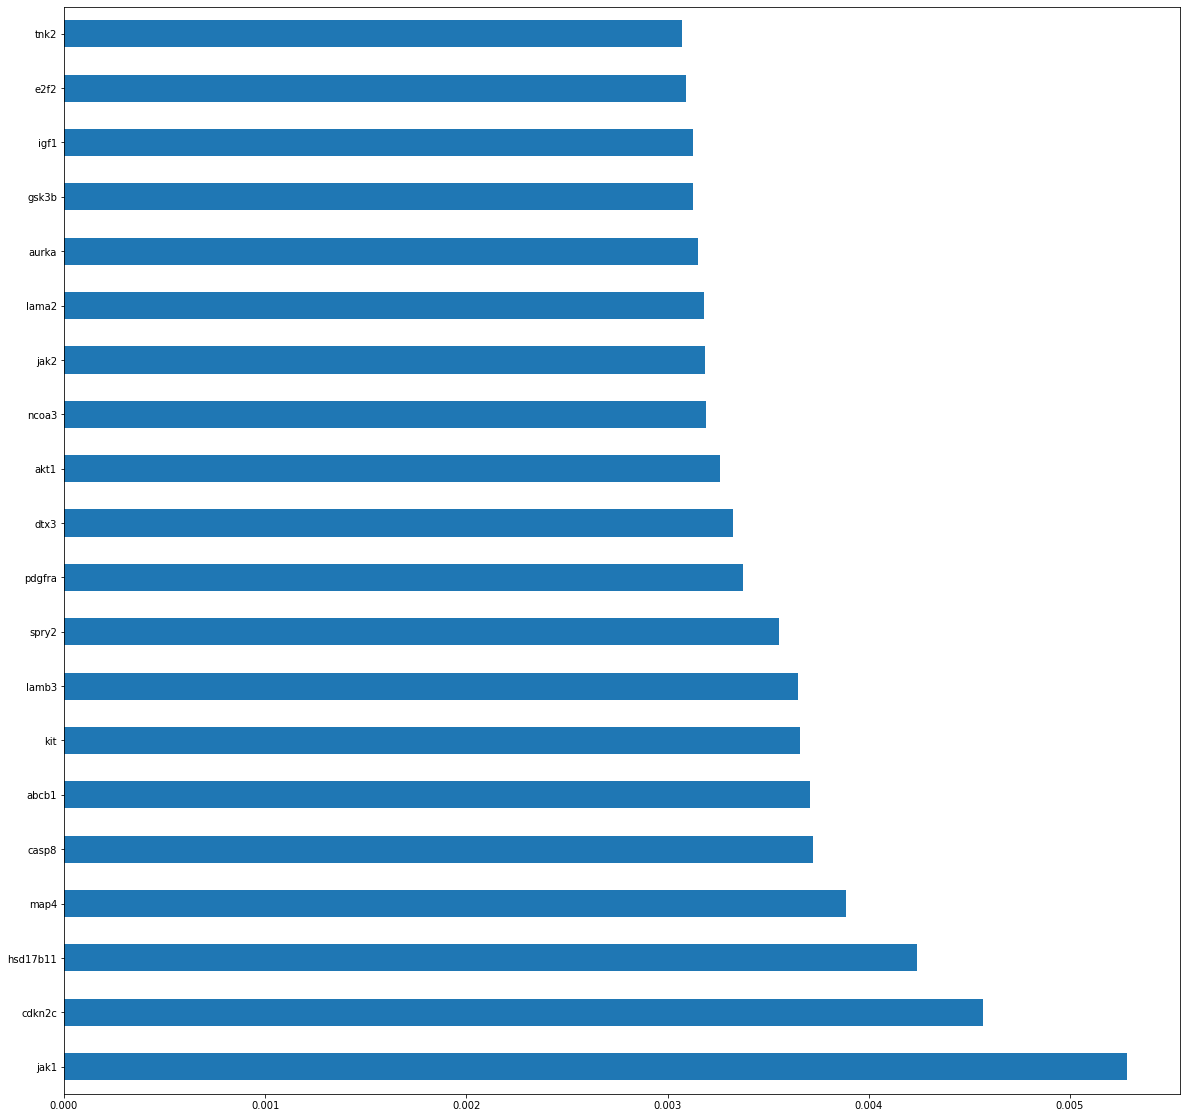

In [ ]:
model = ExtraTreesClassifier()
model.fit(X, y)
max_count = 20

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(max_count).plot(kind='barh', figsize=(20, 20))
plt.show()

In [ ]:
# most important cols found with extra tree

n_largest = 64
most_important_cols = feat_importances.nlargest(n_largest).index
len(most_important_cols)

64

In [ ]:
filtered_gene_exp_df = gene_exp_df[most_important_cols]
filtered_gene_exp_df

,jak1,cdkn2c,hsd17b11,map4,casp8,abcb1,kit,lamb3,spry2,pdgfra,...,notch3,syne1,nfkb1,ran,mmp11,akt2,epcam,tgfb3,mecom,mmp17
0,1.1097,6.4965,1.6822,-0.3917,0.1816,1.6758,2.9336,1.8590,2.8796,1.6642,...,-0.8725,3.5103,-0.8838,0.6630,-3.2039,0.2391,-0.3721,-1.4828,1.1211,0.0194
1,0.9804,0.5189,-0.7837,0.9038,1.8819,-1.1793,-0.4866,-1.2531,0.2446,0.5016,...,-1.4752,0.7871,-0.8477,-0.2505,0.5243,0.6519,0.5600,0.4945,-1.8732,0.7236
2,1.5835,1.1287,1.6822,-0.6845,0.6432,-0.4457,0.4321,1.2534,0.4593,1.8002,...,0.3654,1.6215,-1.2457,0.2707,0.7216,1.2371,2.5553,1.1768,0.7079,0.0935
3,0.6194,0.2592,1.4099,-1.0618,-1.1012,-0.8191,-0.5447,-1.0418,1.3361,2.1803,...,-0.5382,1.3334,-2.0421,1.7962,0.1539,-0.1938,4.1161,1.0085,0.1474,0.4783
4,0.0461,2.6149,0.0493,-0.2336,1.8931,-0.3463,-0.1758,-0.8603,-0.3201,-0.3866,...,-1.4361,-0.6586,-1.3880,1.2930,0.0268,2.1021,0.3349,-0.9729,0.6451,-0.0867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,1.3329,1.0972,1.5955,-0.6714,1.7063,-0.5516,-0.0018,0.1446,0.6390,1.5626,...,-0.5680,1.4207,0.2665,1.4046,0.9418,0.9639,-0.5513,1.1754,-0.2526,-0.1894
1900,-0.1851,-0.1845,0.2741,-0.1385,-0.2765,-0.6707,-0.9795,-0.6787,-0.9980,0.2871,...,-1.1731,0.6718,-0.3832,0.8469,0.2864,2.6758,1.5948,0.8659,-0.4271,1.2644
1901,0.5161,1.0649,0.3877,-1.5584,2.3513,-0.2917,0.2849,-1.2494,-1.1827,-0.6749,...,-1.9473,-0.6754,-1.8658,2.1818,-0.5532,0.0079,1.2695,-1.4053,-0.5147,-0.2521
1902,1.2830,0.1786,0.6109,-0.9498,2.9647,0.6116,-0.1173,-1.0122,-0.7043,-0.3282,...,0.5228,0.7742,-0.8929,1.3851,-0.4537,0.4052,1.5507,-0.6106,-1.5933,0.7297


In [ ]:
filtered_gene_exp_df_train = filter_df(filtered_gene_exp_df, train_patients)
filtered_gene_exp_df_test = filter_df(filtered_gene_exp_df, test_patients)

In [ ]:
print('shapes are:', 
      f'\tfiltered gene exp train: {filtered_gene_exp_df_train.shape}',
      f'\tfiltered gene exp test: {filtered_gene_exp_df_test.shape}',
      sep='\n')

shapes are:
	filtered gene exp train: (1332, 64)
	filtered gene exp test: (572, 64)


### UMAP Reducer

In [ ]:
reducer = UMAP(n_neighbors=15,
               n_components=64,
               metric='euclidean',
               n_epochs=500, 
               learning_rate=1.0,
               init='spectral', 
               min_dist=0.1,
               spread=1.0, 
               set_op_mix_ratio=1.0,
               local_connectivity=1,
               repulsion_strength=1.0,
               negative_sample_rate=5,
               transform_queue_size=4.0,
               random_state=42)

gene_exp_reduced_train = reducer.fit_transform(gene_exp_df_train)
gene_exp_reduced_test = reducer.transform(gene_exp_df_test)


# Check the shape of the new data
print('Shape of gene_exp_reduced_train: ', gene_exp_reduced_train.shape)
print('Shape of gene_exp_reduced_test: ', gene_exp_reduced_test.shape)

Shape of gene_exp_reduced_train:  (1332, 64)
Shape of gene_exp_reduced_test:  (572, 64)


# Classic Model (25 Points)

In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)

## Reduce Dimention and Split Train and Validation Set

### without feature selection

In [ ]:
target_column = "overall_survival"
train_indices, valid_indices = train_test_split(train_patients, test_size=0.25, random_state=42)

gene_exp_reduced_train = reducer.transform(filter_df(gene_exp_df, train_indices))
gene_exp_reduced_val = reducer.transform(filter_df(gene_exp_df, valid_indices))

y_train = list(filter_df(le_clinical_df, train_indices)[target_column])
y_val = list(filter_df(le_clinical_df, valid_indices)[target_column])
y_test = list(clinical_df_test[target_column])

In [ ]:
print(f"length of train set: {len(train_indices)}")
print(f"length of test set: {len(valid_indices)}")

length of train set: 999
length of test set: 333


### with feature selection

In [ ]:
filtered_gene_exp_df_train = filter_df(filtered_gene_exp_df, train_indices)
filtered_gene_exp_df_val = filter_df(filtered_gene_exp_df, valid_indices)

## Train Model on Gene Expressions Dataset after Dimensionality Reduction

### without feature selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(max_depth=6, random_state=42, n_estimators=40, min_samples_split=5)
rfc.fit(gene_exp_reduced_train, y_train)

pred_val = rfc.predict(gene_exp_reduced_val)
accuracy_score(y_val, pred_val)

0.6636636636636637

In [ ]:
pred_test = rfc.predict(gene_exp_reduced_test)
accuracy_score(y_test, pred_test)

0.6118881118881119

### with feature selection

In [ ]:
rfc = RandomForestClassifier(max_depth=6, random_state=42, n_estimators=40, min_samples_split=6)
rfc.fit(filtered_gene_exp_df_train, y_train)

pred_val = rfc.predict(filtered_gene_exp_df_val)
accuracy_score(y_val, pred_val)

0.6486486486486487

In [ ]:
pred_test = rfc.predict(filtered_gene_exp_df_test)
accuracy_score(y_test, pred_test)

0.666083916083916

## Train Model on Gene Expressions Dataset

In [ ]:
rfc = RandomForestClassifier(max_depth=5, random_state=42, n_estimators=50, min_samples_split=4)
rfc.fit(filter_df(gene_exp_df, train_indices), y_train)

pred_val = rfc.predict(filter_df(gene_exp_df, valid_indices))
accuracy_score(y_val, pred_val)

0.6426426426426426

In [ ]:
pred_test = rfc.predict(filter_df(gene_exp_df, test_patients))
accuracy_score(y_test, pred_test)

0.6311188811188811

## Train Model on Clinical Dataset

In [ ]:
clinical_df_columns = list(le_clinical_df.columns)
excluded_columns = ["overall_survival_months", "overall_survival", "death_from_cancer"]
for col in excluded_columns:
    clinical_df_columns.remove(col)

clinical_df_columns

['patient_id',
 'age_at_diagnosis',
 'lymph_nodes_examined_positive',
 'mutation_count',
 'nottingham_prognostic_index',
 'tumor_size',
 'type_of_breast_surgery',
 'cancer_type',
 'cancer_type_detailed',
 'cellularity',
 'chemotherapy',
 'pam50_+_claudin-low_subtype',
 'er_status_measured_by_ihc',
 'er_status',
 'her2_status_measured_by_snp6',
 'her2_status',
 'tumor_other_histologic_subtype',
 'hormone_therapy',
 'inferred_menopausal_state',
 'integrative_cluster',
 'primary_tumor_laterality',
 'oncotree_code',
 'pr_status',
 'radio_therapy',
 '3-gene_classifier_subtype',
 'cohort',
 'neoplasm_histologic_grade',
 'tumor_stage']

In [ ]:
len(clinical_df_columns)

28

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(max_depth=5, random_state=42, n_estimators=50, min_samples_split=4)
rfc.fit(filter_df(le_clinical_df, train_indices)[clinical_df_columns], y_train)

pred_val = rfc.predict(filter_df(le_clinical_df, valid_indices)[clinical_df_columns])
accuracy_score(y_val, pred_val)

0.7027027027027027

In [ ]:
pred_test = rfc.predict(filter_df(le_clinical_df, test_patients)[clinical_df_columns])
accuracy_score(y_test, pred_test)

0.7132867132867133

## Train Model on Clinical Dataset and Gene Expressions Dataset

In [ ]:
mixed_clinical_featSelection_train = np.concatenate((filter_df(le_clinical_df, train_indices)[clinical_df_columns].to_numpy(), filtered_gene_exp_df_train), axis=1)
mixed_clinical_featSelection_val = np.concatenate((filter_df(le_clinical_df, valid_indices)[clinical_df_columns].to_numpy(), filtered_gene_exp_df_val), axis=1)
mixed_clinical_featSelection_test = np.concatenate((filter_df(le_clinical_df, test_patients)[clinical_df_columns].to_numpy(), filtered_gene_exp_df_test), axis=1)

In [ ]:
rfc = RandomForestClassifier(max_depth=6, random_state=42, n_estimators=40, min_samples_split=6)
rfc.fit(mixed_clinical_featSelection_train, y_train)

pred_val = rfc.predict(mixed_clinical_featSelection_val)
accuracy_score(y_val, pred_val)

0.7177177177177178

In [ ]:
pred_test = rfc.predict(mixed_clinical_featSelection_test)
accuracy_score(y_test, pred_test)

0.6940559440559441

# Neural Network (30 Points)

In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)

In [ ]:
import keras
import tensorflow as tf

## Train Model on Gene Expressions Dataset after Dimensionality Reduction

### without feature selection

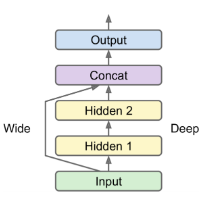

In [ ]:
# Specify the model's architecture
input_layer = tf.keras.Input(64)
hidden1 = tf.keras.layers.Dense(64, activation='relu')(input_layer)
hidden2 = tf.keras.layers.Dense(16, activation='relu')(hidden1)
concat = tf.keras.layers.Concatenate()([input_layer, hidden2])
output_layer = tf.keras.layers.Dense(2, activation='sigmoid')(concat)

model = tf.keras.models.Model(inputs=[input_layer], outputs=[output_layer])

# Specify the loss fuction, optimizer, metrics
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

y_train = np.array(y_train)
y_val = np.array(y_val)

# Train the model
history = model.fit(
    gene_exp_reduced_train, y_train, epochs=50, batch_size=8,
    validation_data=(gene_exp_reduced_val, y_val),
    verbose=1
)

Epoch 1/50
125/125 [==============================] - 1s 4ms/step - loss: 0.8476 - sparse_categorical_accuracy: 0.4214 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.4474
Epoch 2/50
125/125 [==============================] - 0s 2ms/step - loss: 0.7015 - sparse_categorical_accuracy: 0.5025 - val_loss: 0.7085 - val_sparse_categorical_accuracy: 0.5045
Epoch 3/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.5516 - val_loss: 0.7136 - val_sparse_categorical_accuracy: 0.5345
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6906 - sparse_categorical_accuracy: 0.5616 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.5345
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.5596 - val_loss: 0.7105 - val_sparse_categorical_accuracy: 0.5285
Epoch 6/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6896 - sparse_categorica

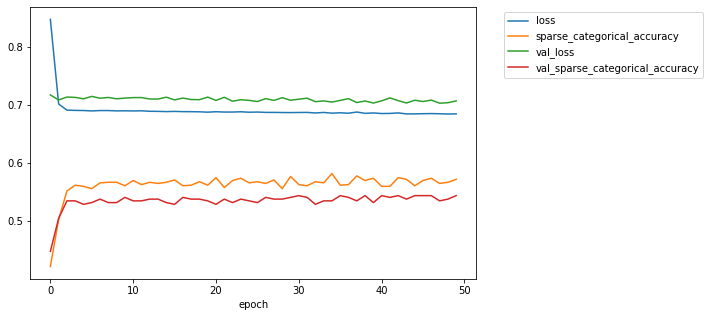

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
y_test = np.array(clinical_df_test[target_column])
loss, mse = model.evaluate(gene_exp_reduced_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.6754 - sparse_categorical_accuracy: 0.6031


### with feature selection

In [ ]:
# Specify the model's architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

# Specify the loss fuction, optimizer, metrics
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

y_train = np.array(y_train)
y_val = np.array(y_val)

# Train the model
history = model.fit(
    filtered_gene_exp_df_train, y_train, epochs=25, batch_size=16,
    validation_data=(filtered_gene_exp_df_val, y_val),
    verbose=1
)

Epoch 1/25
63/63 [==============================] - 3s 10ms/step - loss: 0.6977 - sparse_categorical_accuracy: 0.5365 - val_loss: 0.6672 - val_sparse_categorical_accuracy: 0.5856
Epoch 2/25
63/63 [==============================] - 0s 6ms/step - loss: 0.6699 - sparse_categorical_accuracy: 0.5756 - val_loss: 0.6472 - val_sparse_categorical_accuracy: 0.6096
Epoch 3/25
63/63 [==============================] - 1s 11ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.6006 - val_loss: 0.6362 - val_sparse_categorical_accuracy: 0.6336
Epoch 4/25
63/63 [==============================] - 1s 14ms/step - loss: 0.6447 - sparse_categorical_accuracy: 0.6056 - val_loss: 0.6286 - val_sparse_categorical_accuracy: 0.6426
Epoch 5/25
63/63 [==============================] - 0s 4ms/step - loss: 0.6361 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.6244 - val_sparse_categorical_accuracy: 0.6517
Epoch 6/25
63/63 [==============================] - 0s 4ms/step - loss: 0.6294 - sparse_categorical_accurac

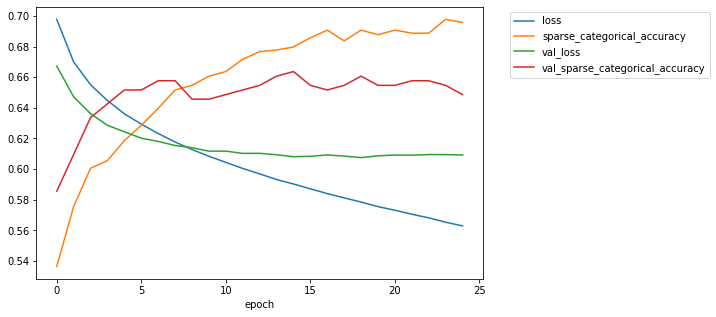

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
y_test = np.array(clinical_df_test[target_column])
loss, mse = model.evaluate(filtered_gene_exp_df_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.6545 - sparse_categorical_accuracy: 0.6329


## Train Model on Gene Expressions Dataset

In [ ]:
# Specify the model's architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(489, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

# Specify the loss fuction, optimizer, metrics
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(1e-5),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

y_train = np.array(y_train)
y_val = np.array(y_val)

# Train the model
history = model.fit(
    filter_df(gene_exp_df, train_indices), y_train, epochs=20, batch_size=8,
    validation_data=(filter_df(gene_exp_df, valid_indices), y_val),
    verbose=1
)

Epoch 1/20
125/125 [==============================] - 4s 13ms/step - loss: 0.8194 - sparse_categorical_accuracy: 0.4905 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.5345
Epoch 2/20
125/125 [==============================] - 1s 6ms/step - loss: 0.7502 - sparse_categorical_accuracy: 0.5315 - val_loss: 0.7130 - val_sparse_categorical_accuracy: 0.5706
Epoch 3/20
125/125 [==============================] - 1s 6ms/step - loss: 0.7256 - sparse_categorical_accuracy: 0.5475 - val_loss: 0.6965 - val_sparse_categorical_accuracy: 0.5916
Epoch 4/20
125/125 [==============================] - 1s 6ms/step - loss: 0.6827 - sparse_categorical_accuracy: 0.5916 - val_loss: 0.6869 - val_sparse_categorical_accuracy: 0.5976
Epoch 5/20
125/125 [==============================] - 1s 7ms/step - loss: 0.6708 - sparse_categorical_accuracy: 0.6116 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.6156
Epoch 6/20
125/125 [==============================] - 1s 9ms/step - loss: 0.6582 - sparse_categoric

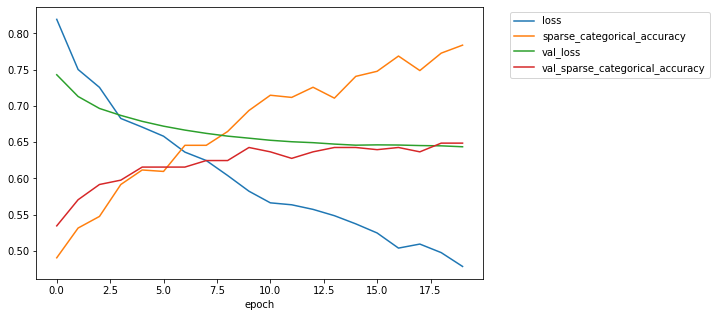

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
y_test = np.array(clinical_df_test[target_column])
loss, mse = model.evaluate(filter_df(gene_exp_df, test_patients), y_test)

18/18 [==============================] - 0s 3ms/step - loss: 0.6575 - sparse_categorical_accuracy: 0.6031


## Train Model on Clinical Dataset

In [ ]:
X_train = filter_df(le_clinical_df, train_indices)[clinical_df_columns]
X_val = filter_df(le_clinical_df, valid_indices)[clinical_df_columns]
X_test = filter_df(le_clinical_df, test_patients)[clinical_df_columns]

In [ ]:
from sklearn.preprocessing import StandardScaler


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [ ]:
# Specify the model's architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(28, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

# Specify the loss fuction, optimizer, metrics
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(1e-4),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

# Train the model
history = model.fit(
    X_train, y_train, epochs=50, batch_size=8,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
125/125 [==============================] - 2s 7ms/step - loss: 0.7744 - sparse_categorical_accuracy: 0.4685 - val_loss: 0.7818 - val_sparse_categorical_accuracy: 0.4565
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 0.7269 - sparse_categorical_accuracy: 0.5215 - val_loss: 0.7373 - val_sparse_categorical_accuracy: 0.4895
Epoch 3/50
125/125 [==============================] - 1s 4ms/step - loss: 0.6942 - sparse_categorical_accuracy: 0.5546 - val_loss: 0.7049 - val_sparse_categorical_accuracy: 0.5405
Epoch 4/50
125/125 [==============================] - 1s 4ms/step - loss: 0.6713 - sparse_categorical_accuracy: 0.5966 - val_loss: 0.6826 - val_sparse_categorical_accuracy: 0.5826
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 0.6555 - sparse_categorical_accuracy: 0.6146 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.6036
Epoch 6/50
125/125 [==============================] - 0s 2ms/step - loss: 0.6440 - sparse_categorica

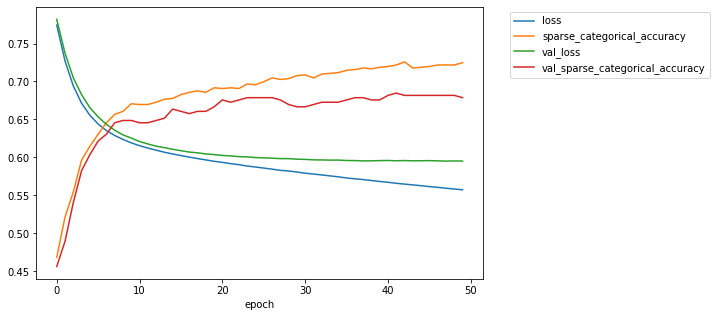

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
y_test = np.array(clinical_df_test[target_column])
loss, mse = model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.5870 - sparse_categorical_accuracy: 0.6871


## Train Model on Clinical Dataset and Gene Expressions Dataset

In [ ]:
mixed_clinical_featSelection_train = np.concatenate((filter_df(le_clinical_df, train_indices)[clinical_df_columns].to_numpy(), filtered_gene_exp_df_train), axis=1)
mixed_clinical_featSelection_val = np.concatenate((filter_df(le_clinical_df, valid_indices)[clinical_df_columns].to_numpy(), filtered_gene_exp_df_val), axis=1)
mixed_clinical_featSelection_test = np.concatenate((filter_df(le_clinical_df, test_patients)[clinical_df_columns].to_numpy(), filtered_gene_exp_df_test), axis=1)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(mixed_clinical_featSelection_train)
X_val = sc.transform(mixed_clinical_featSelection_val)
X_test = sc.transform(mixed_clinical_featSelection_test)

In [ ]:
# Specify the model's architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

# Specify the loss fuction, optimizer, metrics
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(1e-4),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

y_train = np.array(y_train)
y_val = np.array(y_val)

# Train the model
history = model.fit(
    X_train, y_train, epochs=50, batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
63/63 [==============================] - 2s 9ms/step - loss: 0.7897 - sparse_categorical_accuracy: 0.5516 - val_loss: 0.7662 - val_sparse_categorical_accuracy: 0.5435
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 0.7300 - sparse_categorical_accuracy: 0.5796 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.5676
Epoch 3/50
63/63 [==============================] - 0s 6ms/step - loss: 0.6899 - sparse_categorical_accuracy: 0.6006 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.6036
Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6615 - sparse_categorical_accuracy: 0.6146 - val_loss: 0.6499 - val_sparse_categorical_accuracy: 0.6246
Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.6376 - val_loss: 0.6315 - val_sparse_categorical_accuracy: 0.6366
Epoch 6/50
63/63 [==============================] - 0s 4ms/step - loss: 0.6201 - sparse_categorical_accuracy: 

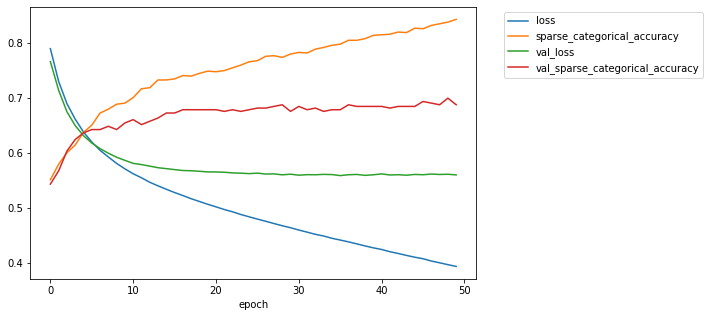

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
y_test = np.array(clinical_df_test[target_column])
loss, mse = model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 0.6200 - sparse_categorical_accuracy: 0.6871


# Model Comparison (10 Points)

## Models on Gene Expressions Dataset after Dimensionality Reduction

> In this part, feature selection with the help of extra trees gives us more informative features than UMAP. So that training models on features extracted with the help of extra trees gives us better accuracy than the other one (both the random forest model and the neural network model).

> The random forest and neural network models on each discussed dataset have almost the same accuracy.

## Models on Gene Expressions Dataset

> In this part, we conclude that the random forest model works better than the neural network model (it has a 3% higher accuracy than the neural network model).

## Models on Clinical Dataset

> In this part, we conclude that the random forest model works better for categorical datasets like clinical datasets. For the random forest model, we used the clinical dataset after excluding three columns, but for the neural network model, we applied `StandardScalar` preprocessing to the clinical dataset. Before applying this preprocessing method, the neural network model was not learning well. As we can see, the random forest model's accuracy on this dataset is 71%, while the neural network model's accuracy is 68%.

## Model on Clinical Dataset and Gene Expressions Dataset

> In this part, we conclude that adding the gene expressions dataset to the clinal dataset does not add new information to the model. So, the random forest model's accuracy on this dataset is 69%, while the neural network model's accuracy is 68%, which is almost the same.